In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time

# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis>np.pi, dis-2*np.pi, dis)
    dis = np.where(dis<-np.pi, dis+2*np.pi, dis)
    # dis[dis > np.pi] -= 2 * np.pi
    # dis[dis < -np.pi] += 2 * np.pi
    return dis
# 默认参数

In [5]:

# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p/L
rho_g = rho_p
num_g = int(rho_g*2*np.pi) # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p/Lambda*2*np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p/25
# divisive normalization
k_p = 20.
k_g = Lambda/2/np.pi * k_p
# time constants
tau_p = 1
tau_g = 2*np.pi * tau_p/Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05

# sigma
# Ag = bm.ones([M])
# Ap = 1.
Ag = 1./(4*np.sqrt(np.pi)*a_g*rho_g*k_g)*(rho_g*J_g+np.sqrt((rho_g*J_g)**2-8*np.sqrt(2*np.pi)*a_g*rho_g*k_g))
Ap = 1./(4*np.sqrt(np.pi)*a_p*rho_p*k_p)*(rho_p*J_p+np.sqrt((rho_p*J_p)**2-8*np.sqrt(2*np.pi)*a_p*rho_p*k_p))
Rp = Ap**2/(1+k_p*rho_p*a_p*np.sqrt(2*np.pi)*Ap**2)
Rg = Ag**2/(1+k_g*rho_g*a_g*np.sqrt(2*np.pi)*Ag**2)
print(Ap)
print(Ag)
print(Rg)
# Ap = 1.0084058
# Rp = 0.0128615275
# Ag = 0.9814125
# Rg = 0.013212965

sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g)) 
sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp))
sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p)) 
ratio = 0.005
print('sigma_p:', sigma_p*ratio)
print('sigma_g:', sigma_g*ratio)
print('sigma_phi:', sigma_phi*ratio)
P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
### Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num = num_g, num_hpc=num_p, L = Lambda[i], a_g = a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)


0.9186013138708921
[0.91860131 0.91860131 0.91860131]
[0.01948648 0.01948648 0.01948648]
sigma_p: 0.08736587059802968
sigma_g: [0.08736587 0.08736587 0.08736587]
sigma_phi: [0.08805847 0.06604385 0.05283508]


In [158]:

def GOP_decoding(z_t, phi_t, Ip, Ig, alpha_p_infer, alpha_g_infer, Ag=Ag, Ap=Ap, Rp=Rp, total_iterations=5000):  
    sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g_infer)) 
    sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp))    
    sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p_infer)) 
    sigma_g_infer = sigma_g*ratio
    sigma_phi_infer = sigma_phi*ratio
    sigma_p_infer = sigma_p*ratio
    eta = 20.*1e-6
    '''
    GOP: Gradient based Optimization of Posterior
    Ip shape [n_p]
    Ig shape [M, n_g]
    '''
    z_ts = []
    phi_ts = []
    z_ts.append(z_t)
    phi_ts.append(phi_t)
    z_encode_space = np.linspace(0,L,num_p,endpoint=False)

    for iteration in range(total_iterations):
        # phi_z = np.mod(z_t / Lambda, 1) * 2 * np.pi
        # fg = np.zeros((M, num_g))
        fg_prime = np.zeros((M, num_g))
        for i in range(M):
            dis_theta = circ_dis(theta, phi_t[i])
            # fg[i, :] = np.exp(-dis_theta**2 / (4 * a_g[i] ** 2))
            fg_prime[i, :] = dis_theta / (2 * a_g[i] ** 2) * np.exp(-dis_theta**2 / (4 * a_g[i] ** 2))

        dis_z = z_encode_space-z_t
        # fp = np.exp(-dis_z**2 / (4 * a_p**2))
        fp_prime = dis_z / (2 * a_p ** 2) * np.exp(-dis_z**2 / (4 * a_p ** 2))
        
        ## compute the log likelihood
        # partial ln P(rg|phi) / partial phi
        Ig_fgprime_prod = Ig * fg_prime # shape [M, n_g]
        Ig_fgprime_prod = np.sum(Ig_fgprime_prod, axis=1) # shape [M]
        dphi_fr = Ig_fgprime_prod /  sigma_g_infer**2 
        # print(dphi_fr)

        # partial ln P(rp|z) / partial z
        Ip_fp_prime_prod = Ip * fp_prime # shape [n_p]
        Ip_fp_prime_prod = np.sum(Ip_fp_prime_prod) # shape [1]
        dr_fr = Ip_fp_prime_prod / sigma_p_infer**2
        
        ## transition model
        phi_z = np.mod(z_t / Lambda, 1) * 2 * np.pi
        dis_phi = circ_dis(phi_z, phi_t) # shape [M]
        # partial ln P(phi|z) / partial phi
        dphi_tr = 1 / sigma_phi_infer**2 * dis_phi # shape [M]
        # partial ln P(phi|z) / partial z
        dr_tr = np.sum(-2*np.pi/(Lambda * sigma_phi_infer**2) * dis_phi)
        # print(dr_tr)
        ## update
        dphi = dphi_fr + dphi_tr
        phi_t = phi_t + eta * dphi
        # boundary condition
        phi_t = np.mod(phi_t, 2 * np.pi)
        dr = dr_fr + dr_tr
        z_t = z_t + eta * dr


        ## record
        z_ts.append(z_t)
        phi_ts.append(phi_t)
    return np.array(z_ts), np.array(phi_ts)


def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p = 0.05, alpha_g = 0.05, Coupled_model=Coupled_model):
    ### Place cells

    ### Coupled Network
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        Imec = Coupled_model.I_mec
        rg = bm.zeros([M,num_g])
        ug = bm.zeros([M,num_g])
        for mi in range(M):
            rg[mi,:] = Coupled_model.MEC_model_list[mi].r
            ug[mi,:] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug, Imec

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta**2 / (4 * a_g[i] ** 2))
    x = np.linspace(0,L,num_p,endpoint=False)
    dis_x = x-z0
    fp = np.exp(-dis_x**2 / (4 * a_p**2))
    I_place = 1*np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1*np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init/3):,:] = 0
    I_grid[int(T_init/3):,:,:] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p*np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g*np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug, Imec = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg, Imec


0.14067996567636346


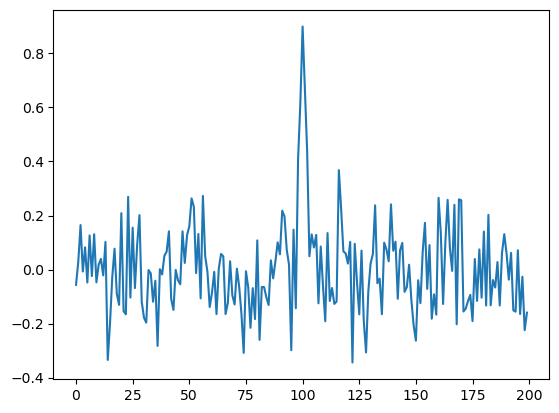

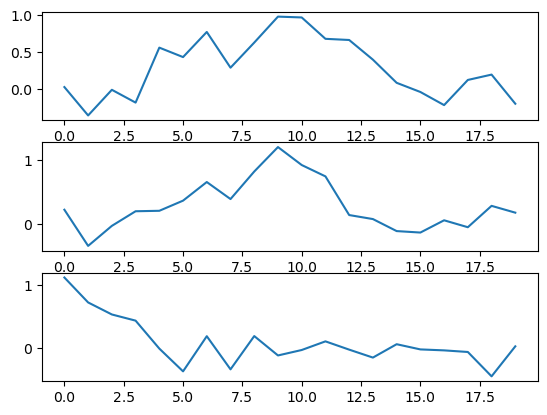

In [159]:

z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
z_e = z_truth
psi = phi_truth + sigma_phi * np.random.randn(M)
Ig = np.zeros((M, num_g))
for j in range(M):
    dis_theta = circ_dis(theta, psi[j])
    Ig[j, :] = np.exp(-dis_theta**2 / (4 * a_g[j] ** 2)) + 1.5*sigma_g[j] * ratio * np.random.randn(num_g)
x = np.linspace(0,L,num_p,endpoint=False)
dis_x = x-z_e
Ip = np.exp(-dis_x**2 / (4 * a_p**2)) + sigma_p * np.random.randn(num_p) * ratio
plt.plot(Ip)
fig, ax = plt.subplots(M,1)
for i in range(M):
    ax[i].plot(Ig[i,:])
print(sigma_p*ratio)


0.9973339 0.018995214 [0.91105956 0.99180794 0.96641684] [0.02000744 0.02073348 0.01986162]


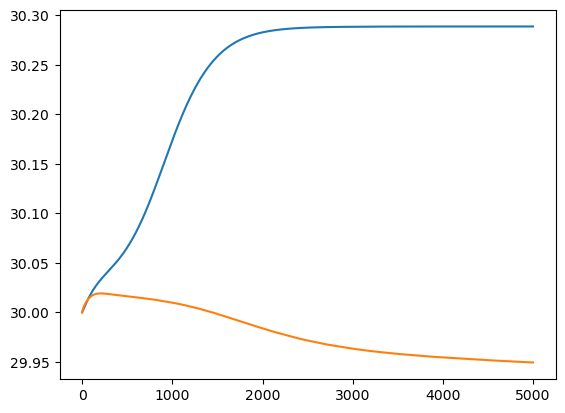

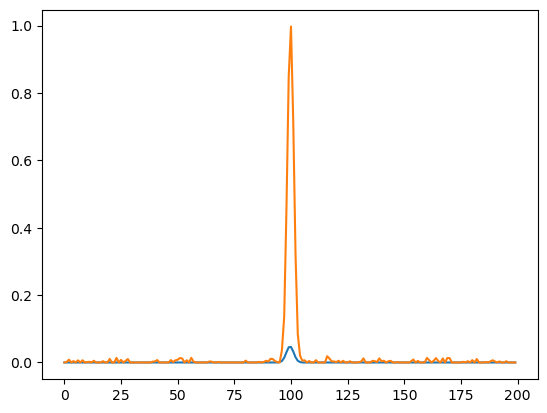

In [160]:
z_decode_net, _, up, rp, ug, rg, Imec = Net_decoding(z_truth, phi_truth, Ip, Ig)

max_up = np.max(up,axis=1)
max_rp = np.max(rp,axis=1)
Ap = np.max(max_up[-1])
Rp = np.max(max_rp[-1])
Ag = np.zeros(M,)
Rg = np.zeros(M,)
for mi in range(M):
    max_ug = np.max(ug[:,mi,:],axis=1)
    max_rg = np.max(rg[:,mi,:],axis=1)
    Ag[mi] = np.max(max_ug[-1])
    Rg[mi] = np.max(max_rg[-1])
z_decode_gop, _ = GOP_decoding(z_t=z_truth, phi_t=phi_truth, Ip=Ip, Ig=Ig, alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag)

plt.figure()
plt.plot(z_decode_gop)
plt.plot(z_decode_net)
print(Ap, Rp, Ag, Rg)
# print(z_decode_gop.shape)
plt.figure()
plt.plot(Imec[-1,:])
plt.plot(up[-1,:])
# plt.plot(z_decode_net)